# Import Libraries & Load Dataset

In [1]:
# Import pandas, numpy, and matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the Excel file and parse the correct sheet
path = 'https://gitlab.crio.do/me_notebook/me_jupyter_uberanalysis/-/raw/master/Uber_ride_analysis_dataset.csv'
df = pd.read_csv(path,header=0)
df.head()

,Request id,Pickup point,Drop point,Request timestamp,Start timestamp,Drop timestamp,Trip Cost,Extra Tip,Driver id,Trip Status,Ride Type,Payment Method,Weather
0,4386.0,Majestic Bus Station,Bangalore Palace,2021-07-13 0:00:24,NaN,NaN,0.00,0.0,61.0,Trip Cancelled,UberXL,NaN,Clear
1,4387.0,Lalbagh Botanical Garden,Indiranagar,2021-07-13 0:02:14,2021-07-13 0:16:00,2021-07-13 0:26:14,111.38,0.0,17.0,Trip Completed,UberGo,Cash,Cloudy
2,4388.0,Lalbagh Botanical Garden,Kormangala Police Station,2021-07-13 0:06:34,2021-07-13 0:14:01,2021-07-13 2:01:34,89.00,25.0,21.0,Trip Completed,UberXL,Card,Clear
3,4389.0,Majestic Bus Station,ISKCON Temple,2021-07-13 0:07:31,NaN,NaN,0.00,0.0,NaN,No Cars Available,UberXL,NaN,Rainy
4,4390.0,Bangalore City Railway Station,Lalbagh Botanical Garden,2021-07-13 0:07:58,2021-07-13 0:20:21,2021-07-13 0:40:58,307.40,25.0,35.0,Trip Completed,UberGo,Cash,Rainy


# Data Cleaning

In [3]:
# Standardize column names
# Convert to lowercase and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns

Index(['request_id', 'pickup_point', 'drop_point', 'request_timestamp',
       'start_timestamp', 'drop_timestamp', 'trip_cost', 'extra_tip',
       'driver_id', 'trip_status', 'ride_type', 'payment_method', 'weather'],
      dtype='object')

In [4]:
# Identify missing values in each column
print(df.isnull().sum())

request_id            200
pickup_point          200
drop_point            200
request_timestamp     200
start_timestamp      1850
drop_timestamp       1850
trip_cost             200
extra_tip             200
driver_id             975
trip_status           200
ride_type             200
payment_method       1850
weather               200
dtype: int64


In [5]:
# Drop rows with missing trip status or trip cost
df = df.dropna(subset=['trip_status', 'trip_cost'])

In [6]:
# Fill missing payment method with mode
df['payment_method'].fillna(df['payment_method'].mode()[0], inplace=True)

/tmp/ipykernel_143/4126109900.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['payment_method'].fillna(df['payment_method'].mode()[0], inplace=True)


In [7]:
# Fill missing driver ID with -1 (indicates unassigned)
df['driver_id'].fillna(-1, inplace=True)

/tmp/ipykernel_143/1066594594.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['driver_id'].fillna(-1, inplace=True)


In [8]:
#  Handle timestamps conditionally
# Drop rows where timestamps are missing only for 'Trip Completed'
df = df[~((df['trip_status'] == 'Trip Completed') & (df['start_timestamp'].isna() | df['drop_timestamp'].isna()))]

In [9]:
# Identify missing values in each column
print(df.isnull().sum())

request_id              0
pickup_point            0
drop_point              0
request_timestamp       0
start_timestamp      1650
drop_timestamp       1650
trip_cost               0
extra_tip               0
driver_id               0
trip_status             0
ride_type               0
payment_method          0
weather                 0
dtype: int64


In [10]:
# Convert date columns to datetime
date_columns = ['request_timestamp', 'start_timestamp', 'drop_timestamp']
for col in date_columns:
    df[col] = pd.to_datetime(df[col])

In [11]:
#  List all numeric columns
numeric_columns = df.select_dtypes(include='number').columns.tolist()
print(numeric_columns)

['request_id', 'trip_cost', 'extra_tip', 'driver_id']


## Outlier Detection and Treatment

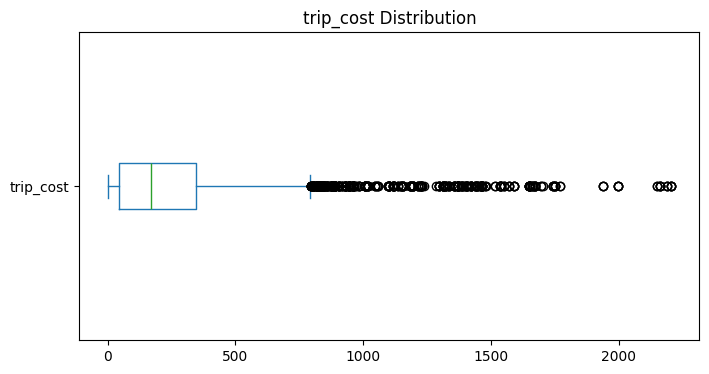

In [12]:
# Plot boxplot for trip cost
plt.figure(figsize=(8, 4))
df['trip_cost'].plot(kind='box', vert=False)
plt.title('trip_cost Distribution')
plt.show()

In [13]:
# Detect and cap outliers in trip cost using IQR
Q1 = df['trip_cost'].quantile(0.25)
Q3 = df['trip_cost'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
df['trip_cost'] = np.where(df['trip_cost'] > upper_bound, upper_bound, df['trip_cost'])

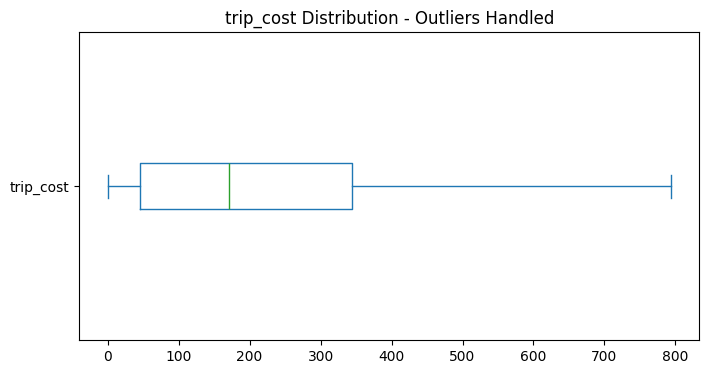

In [14]:
# Plot boxplot for trip cost
plt.figure(figsize=(8, 4))
df['trip_cost'].plot(kind='box', vert=False)
plt.title('trip_cost Distribution - Outliers Handled')
plt.show()

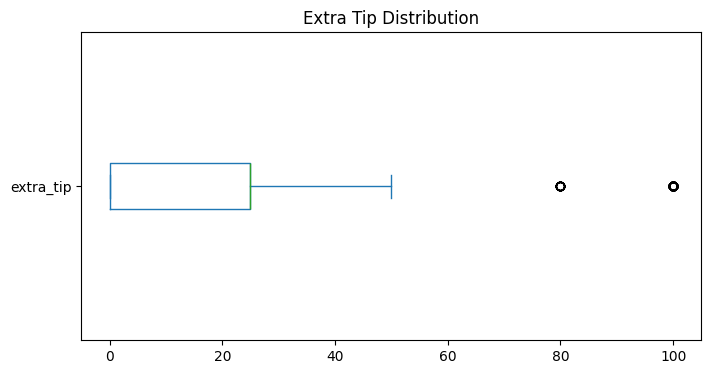

In [15]:
#  Repeat for extra tip
plt.figure(figsize=(8, 4))
df['extra_tip'].plot(kind='box', vert=False)
plt.title('Extra Tip Distribution')
plt.show()


# 📊 Exploratory Data Analysis (EDA)

Now that the data cleaning is done, let's perform EDA to understand the dataset better and derive insights.


## 1. Dataset Overview

In [16]:
# Understand the shape of the dataset
df.shape

(6745, 13)

In [17]:
# Understand the datatypes of the columns
df.dtypes

request_id                  float64
pickup_point                 object
drop_point                   object
request_timestamp    datetime64[ns]
start_timestamp      datetime64[ns]
drop_timestamp       datetime64[ns]
trip_cost                   float64
extra_tip                   float64
driver_id                   float64
trip_status                  object
ride_type                    object
payment_method               object
weather                      object
dtype: object

## 2. Trip Status Breakdown

Text(0.5, 1.0, 'Trip Status Distribution')

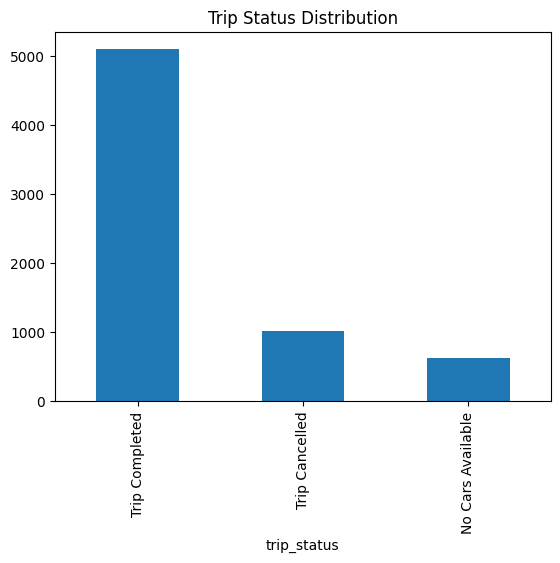

In [18]:
# Plot the value_counts for different trip statuses
df['trip_status'].value_counts().plot(kind='bar')
plt.title("Trip Status Distribution")

## 3. Trip Cost Distribution

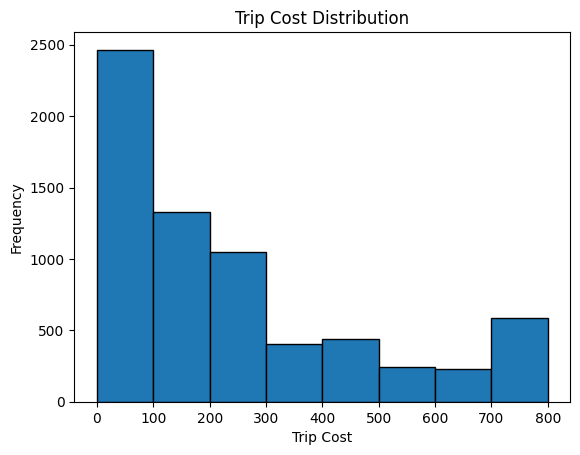

In [19]:
# Plot Trip Cost Distribution
# Define bin edges at intervals of 100, starting from 0 up to the maximum trip cost
# Plot the histogram with the specified bins
# Turn off grid

import numpy as np
import matplotlib.pyplot as plt

max_cost = df['trip_cost'].max()
bins = np.arange(0, max_cost + 100, 100)

df['trip_cost'].hist(bins=bins, edgecolor='black')
plt.title("Trip Cost Distribution")
plt.xlabel("Trip Cost")
plt.ylabel("Frequency")
plt.grid(False)  
plt.show()

## 4. Analyze Payment Methods

In [20]:
# Analyze trip costs across payment methods by calculating the average, median, and number of trips for each method,
# and sort the results to highlight the most expensive payment types on average

df.groupby('payment_method')['trip_cost'].agg(['mean', 'median', 'count']).sort_values(by='mean', ascending=False)

,mean,median,count
payment_method,,,
Card,316.517799,231.50,1708
UPI,315.056717,233.75,1663
Cash,156.880047,45.00,3374


## 5. Trip Duration Analysis


In [21]:
# Compute the trip duration in minutes by taking the difference between drop and start timestamps
df['trip_duration_minutes'] = (df['drop_timestamp'] - df['start_timestamp']).dt.total_seconds() / 60

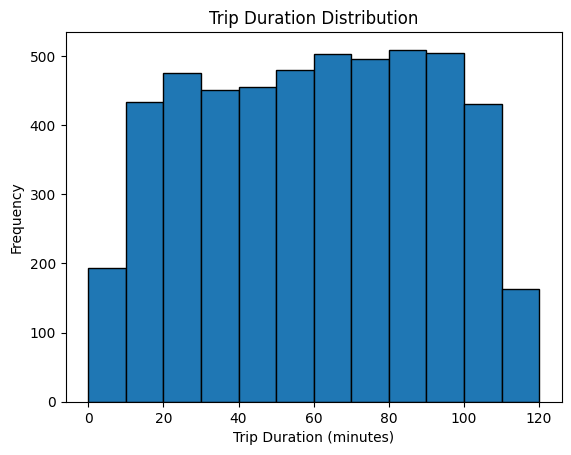

In [22]:
# Plot distribution of trip duration
# Define bins with a fixed size (e.g., every 10 minutes)
# Grid should not be visible
import numpy as np
import matplotlib.pyplot as plt

max_duration = df['trip_duration_minutes'].max()
bins = np.arange(0, max_duration + 10, 10)  # bins of size 10 minutes

# Plot histogram
df['trip_duration_minutes'].hist(bins=bins, edgecolor='black')
plt.title("Trip Duration Distribution")
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Frequency")
plt.grid(False)  
plt.show()

# Transforming Data

## 1. Total Trip Cost

In [23]:
# Calculate Total cost of the trip

df['total_cost'] = df['trip_cost'] + df['extra_tip']

## 2. DateTime Columns

In [24]:
# Convert Time Columns to DateTime Format

df['request_timestamp'] = pd.to_datetime(df['request_timestamp'])
df['start_timestamp'] = pd.to_datetime(df['start_timestamp'])
df['drop_timestamp'] = pd.to_datetime(df['drop_timestamp'])

## 3. Extract Date Time

In [25]:
# Extract Date and Time Components
'''
From the relevant datetime column(s), extract:
1. Date (YYYY-MM-DD) (request_date, start_date, drop_date)
2. Day of the week (e.g., Monday, Tuesday) (request_day, start_day, drop_day)
3. Exact time (HH:MM:SS) (request_time, start_time, drop_time)
4. Hour of the day (0–23) (request_hour, start_hour, drop_hour)
'''

df['request_date'] = df['request_timestamp'].dt.date
df['start_date'] = df['start_timestamp'].dt.date
df['drop_date'] = df['drop_timestamp'].dt.date

df['request_day'] = df['request_timestamp'].dt.day_name()
df['start_day'] = df['start_timestamp'].dt.day_name()
df['drop_day'] = df['drop_timestamp'].dt.day_name()

df['request_time'] = df['request_timestamp'].dt.time
df['start_time'] = df['start_timestamp'].dt.time
df['drop_time'] = df['drop_timestamp'].dt.time

df['request_hour'] = df['request_timestamp'].dt.hour
df['start_hour'] = df['start_timestamp'].dt.hour
df['drop_hour'] = df['drop_timestamp'].dt.hour

## 4. Ride Delay

In [26]:
# Calculating the Ride delay.
'''
- Determine the delay between the ride request and actual trip start.
- Add a column ride_delay reflecting this delay in hour value.
'''

df["ride_delay"] = ((df["drop_timestamp"] - df["start_timestamp"]).dt.total_seconds() / 3600).round(2)

## 5. Cancellation Reasons

In [27]:
# Determine Cancellation reasons
# - Assign a cancellation reason to each trip based on the driver_id and trip_status columns using nested np.where() statements.
'''
1. If the driver_id is -1 and the trip status is 'No Cars Available', it indicates that no cab was assigned,
so the cancellation reason is set to 'No Cabs'.
2. If the driver_id is -1 and the trip status is 'Trip Cancelled', it means the passenger canceled the trip before a driver was assigned,
so the reason is 'Passenger'.
3. If a driver was assigned (driver_id not equal to -1) and the trip status is 'Trip Cancelled', it indicates that the driver canceled the trip,
so the reason is 'Driver'.
4. For all other cases—where the trip was completed successfully—the cancellation reason is set to 'Trip Completed'.

'''

df['cancellation_reason'] = np.where(
    (df['driver_id'] == -1) & (df['trip_status'] == 'No Cars Available'), 'No Cabs',
    np.where(
        (df['driver_id'] == -1) & (df['trip_status'] == 'Trip Cancelled'), 'Passenger',
        np.where(
            (df['driver_id'] != -1) & (df['trip_status'] == 'Trip Cancelled'), 'Driver',
            'Trip Completed'
        )
    )
)

# Analysis

Selecting columns relevant to our analysis

In [28]:
# TODO 1 : Creating a New Dataframe selecting columns relevant to our analysis
# All analysis going forward will be done on this new dataframe created
selected_columns = [
    'request_id', 'driver_id', 'trip_status', 'request_day', 'request_hour',
    'start_day', 'start_hour', 'drop_day', 'drop_hour', 'ride_delay',
    'trip_cost', 'weather', 'cancellation_reason'
]
new_df = df[selected_columns]

/tmp/ipykernel_143/328250489.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=new_df, x='request_day', palette='Set1')


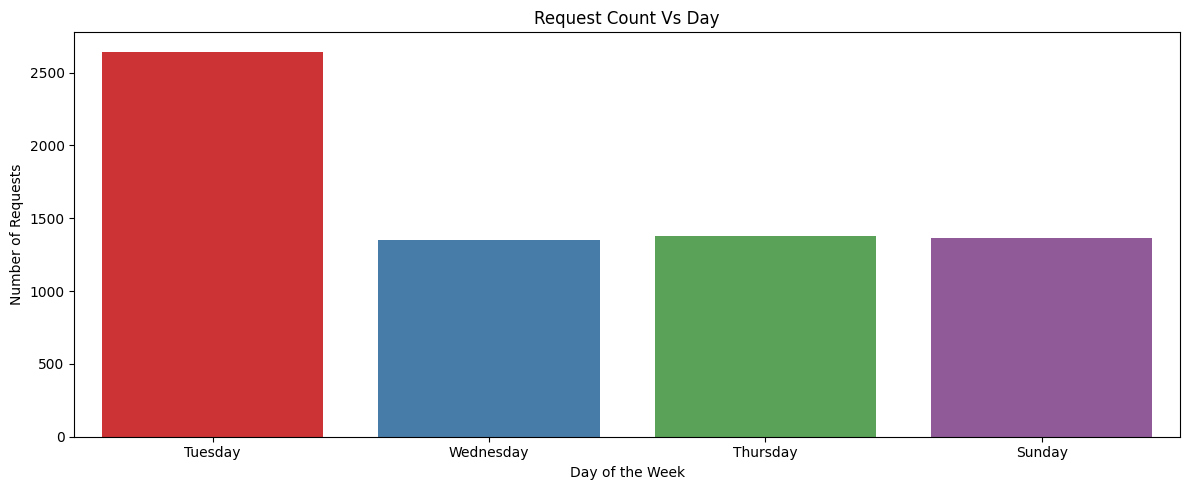

In [29]:
# TODO 2 : Create a bar chart / Count plot (using Seaborn) that shows the number of ride requests for each day of the week (request_day column)
'''
1. Import Seaborn library as sns
2. Use .countlot() to create the chart
3. Assign Title to the chart
    - Title should be → “Request Count Vs Day”
4. Assign X & Y labels
5. (Optional) Assign Figure Size
    - Try (12, 5) or (10, 6) 
6. (Optional) Assign a colour Palette to the chart
    - Try 'Set1' or 'Pastel1' or 'coolwarm' or ‘Blues’, etc.
'''
plt.figure(figsize=(12, 5))
sns.countplot(data=new_df, x='request_day', palette='Set1')
plt.title("Request Count Vs Day")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Requests")
plt.tight_layout()
plt.show()

/tmp/ipykernel_143/946643939.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=new_df, x='request_hour', palette='Pastel1')


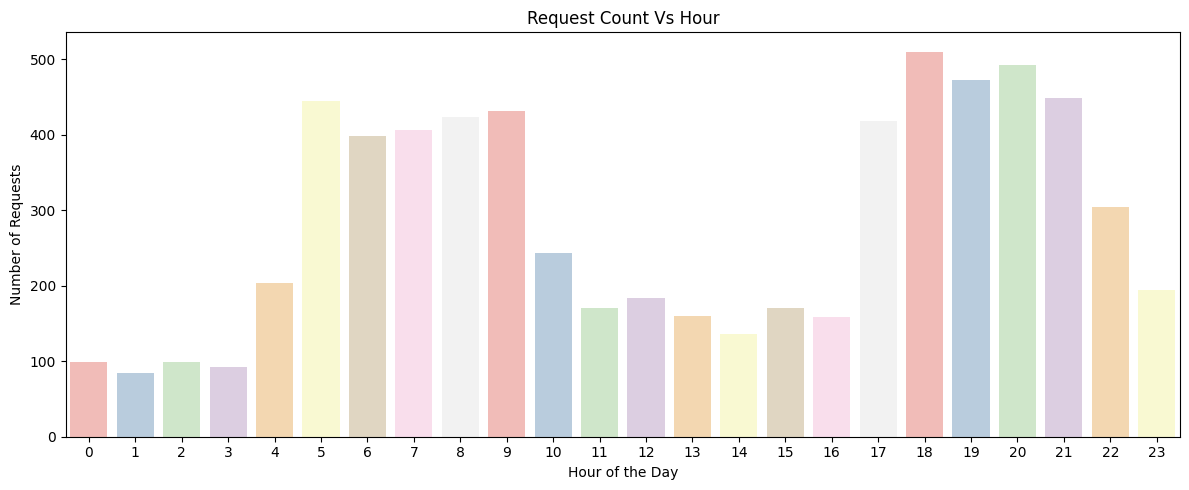

In [30]:
# TODO 3 : Create a bar chart / Count plot (using Seaborn) that shows the number of ride requests for each hour of the day (request_hour column)
'''
1. Use .countlot() to create the chart
2. Assign Title to the chart
    - Title should be → “Request Count Vs Hour”
3. Assign X & Y labels
4. Assign Figure Size
    - Try (12 * 5), (10 * 6) 
5. Assign a colour Palette to the chart
    - Try 'Set1' or 'Pastel1' or 'coolwarm' or ‘Blues’, etc.
'''
plt.figure(figsize=(12, 5))
sns.countplot(data=new_df, x='request_hour', palette='Pastel1')
plt.title("Request Count Vs Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Requests")
plt.tight_layout()
plt.show()

In [31]:
# TODO 4 : Calculate the trip status bifurcation (normalize to percentage)
'''
1. Count the values to create a variable for each value in the trip status column
2. Normalize these to get the percentage of each
    - This calculates the percentage of each unique value in the respective column.
3. Store it in a variable → “trip_status_rates”
4. Print the variable to see the output
'''
trip_status_rates = df['trip_status'].value_counts(normalize=True) * 100
print(trip_status_rates)

trip_status
Trip Completed       75.537435
Trip Cancelled       15.151964
No Cars Available     9.310600
Name: proportion, dtype: float64


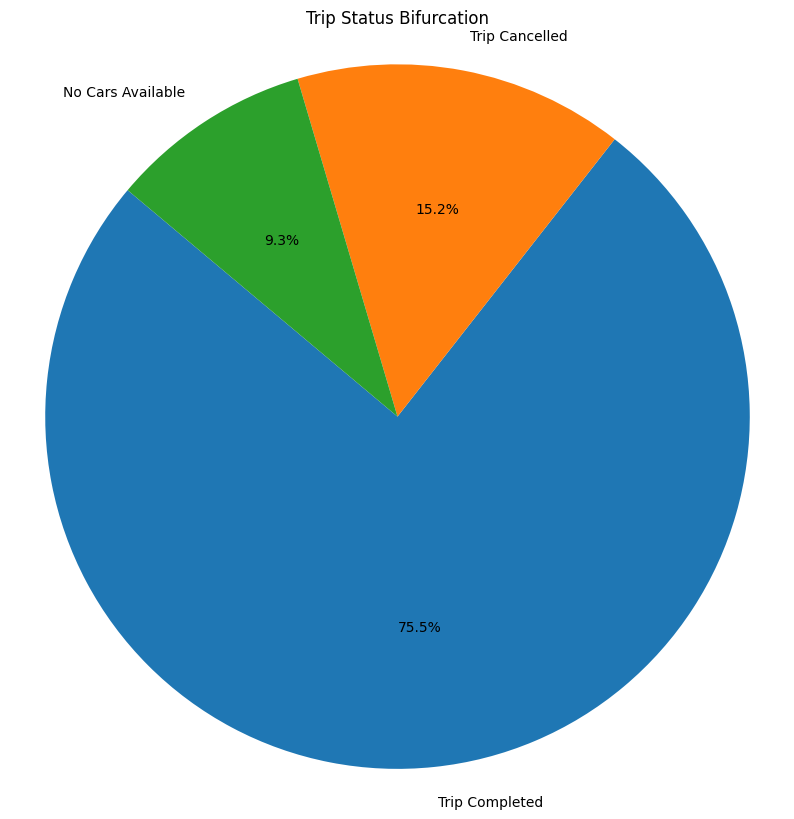

In [32]:
# TODO 5 :  Plotting a pie chart for Trip Status
'''
1. Assign Figure Size
    - Try (10, 10) or (8,  8)
2. Use .pie() to create the chart
    - Add the labels as .index from the calculated variable above
    - Add Percentage of each segment on the chart
        - Use autopct = '%1.1f%%', within the pie chart
        - This formats the percentage to show one decimal point.
3. Assign Title to the chart
    - Title should be → “Trip Status Bifurcation”
'''

plt.figure(figsize=(10, 10))
plt.pie(trip_status_rates, labels=trip_status_rates.index, autopct='%1.1f%%', startangle=140)
plt.title("Trip Status Bifurcation")
plt.axis('equal')
plt.show()

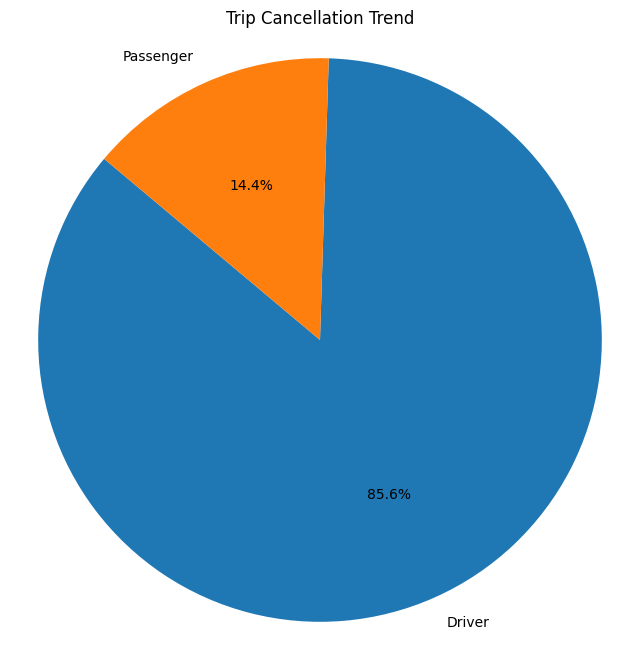

/tmp/ipykernel_143/3785534480.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cancellation_trends.index, y=cancellation_trends.values, palette='coolwarm')


Text(0.5, 0, 'Cancellation Reason')

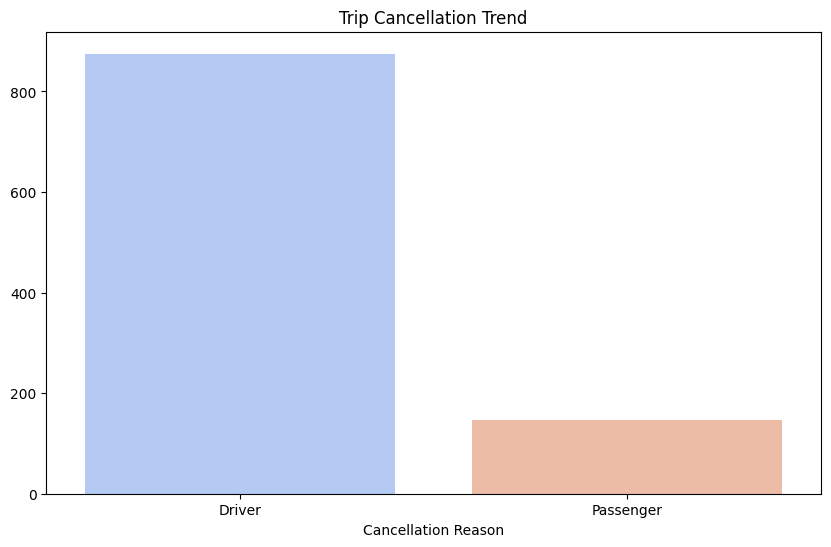

In [33]:
# TODO 6 : Calculate the cancellation trends based on the 'cancellation_reason' column & plot the same
'''
1. Print the cancellation reason counts for cancelled trips.
    - Assign a variable → ‘cancellation_trends’ to find the value counts of each cancellation reason where trip status is ‘Trip Cancelled’
2. Plot a pie chart to visualize the same.
    - Assign Title → ‘Trip Cancellation Trend’ to the chart
4. (Optional) Plot a bar chart for the same.
    - Assign X & Y labels along with title
'''
cancellation_trends = new_df[new_df['trip_status'] == 'Trip Cancelled']['cancellation_reason'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(cancellation_trends, labels=cancellation_trends.index, autopct='%1.1f%%', startangle=140)
plt.title("Trip Cancellation Trend")
plt.axis('equal')
plt.show()


plt.figure(figsize=(10, 6))
sns.barplot(x=cancellation_trends.index, y=cancellation_trends.values, palette='coolwarm')
plt.title("Trip Cancellation Trend")
plt.xlabel("Cancellation Reason")